<font color = "00008B" size = 6> **Clasificación de Imágenes de Resonancia Magnética MRI.**  </font>

<font color = "00008B" size = 5> *Tumores cerebrales.* </font>

<font color = "00008B" size = 3> ***Méndez Moreno Marco Antonio*** </font>

<font color = "00008B" size = 3> 13/12/2022 </font>


------



<font color = "00008B" size = 5> ***¿Qué es un tumor cerebral?*** </font>

Un tumor cerebral es una masa o bulto de células anormales que se encuentra en el cerebro. Existen diferentes tipos de tumores cerebrales, algunos tumores cerebrales no son cancerosos (benignos) y algunos tumores sí lo son (malignos). 

<center> <img src='https://medicine.wustl.edu/wp-content/uploads/GlioblastomaBranScans.jpg' width="450" height="300"/> </center>

Para más información [Tumor cerebral](https://www.mayoclinic.org/es-es/diseases-conditions/brain-tumor/symptoms-causes/syc-20350084).



<font color = "00008B" size = 5> ***Importancia*** </font>

La detección temprana y la clasificación de los tumores cerebrales es un dominio de investigación importante en el campo de las imágenes médicas ya que las opciones de tratamiento del tumor cerebral dependerán del tipo de tumor, así como también de su tamaño y ubicación.

<font color = "00008B" size = 5> ***Acerca del conjunto de datos*** </font>

El conjunto de datos utilizado contiene **7,022** imágenes de resonancia magnética del cerebro clasificados en ***4 clases***: 

*   *No tumor* 
*   *Glioma*
*   *Meningioma* 
*   *Pituitary*

Obtenidos de [*kaggle Brain Tumor MRI Dataset*](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset).

-----

Las imágenes contenidas en el conjunto de datos son de diferentes tamaños, así que requieren un preprocesamiento para ajustar los tamaños.

<font color = "00008B" size = 5> ***PREPARACIÓN DEL DATASET*** </font>



In [1]:
# Importamos todas las librerías que utilizaremos en el proyecto.
from keras import layers
from keras.layers import Input, Dense, Activation, Flatten
from keras.layers import Dropout
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.optimizers import SGD
import keras.backend as K
from keras.layers import BatchNormalization                       
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from random import shuffle
from tensorflow import keras
from tqdm import tqdm
import cv2
import os
import imutils
import tensorflow as tf
import tensorflow_hub as hub

np.random.seed(3)

In [2]:
# Conectamos con nuestro Drive para poder cargar las imágenes.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




---


En el sitio donde se obtuvieron las imágenes nos brinda un código para el *preprocesamiento* de las imágenes y el ajuste de tamaños. Vamos a trabajar con imágenes de $128 \times 128$ pixeles.


---




In [3]:
def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
	
	return new_img
	
if __name__ == "__main__":
	training = "/content/drive/MyDrive/BrainTumorClassification/Training"
	testing = "/content/drive/MyDrive/BrainTumorClassification/Testing"
	training_dir = os.listdir(training)
	testing_dir = os.listdir(testing)
	IMG_SIZE = 128

	for dir in training_dir:
		save_path = 'cleaned/Training/'+ dir
		path = os.path.join(training,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)
	
	for dir in testing_dir:
		save_path = 'cleaned/Testing/'+ dir
		path = os.path.join(testing,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)



---


Como las imágenes se encuentran clasificadas por carpetas vamos a obtener cada una de las imágenes y asignarle su etiqueta correspondiente.

<center>

| Label | Class Name |
| --- | --- |
| 0 | No tumor |
| 1 | Glioma | 										
| 2 | Meningioma |										
| 3 | Pituitary |		

</center>		


---



In [4]:
# Creamos un diccionario para las etiquetas de los datos.
dic = {0: "No tumor", 1: "Glioma", 2: "Meningioma", 3: "Pituitary"}

In [5]:
# Creamos una función que nos ayude a "sacar" las imágenes de las carpetas
# y crear las etiquetas correspondientes.
def dataset(clases, conjunto):

  images = []
  images_labels = []

  for classification in clases:
    images_path_folder = "/content/cleaned/" + conjunto +"/" + classification
    files_names = os.listdir(images_path_folder)

    for file_name in files_names:
      image_path = images_path_folder + "/" + file_name
      image = cv2.imread(image_path)
      images.append(image)

      if classification == "notumor":
        label = 0
        images_labels.append(label)

      if classification == "glioma":
        label = 1
        images_labels.append(label)
      
      if classification == "meningioma":
        label = 2
        images_labels.append(label)
      
      if classification == "pituitary":
        label = 3
        images_labels.append(label)
    
  zipped = list(zip(images, images_labels))
  shuffle(zipped)

  return zipped

<font color = "00008B" size = 3> ***CONJUNTO DE ENTRENAMIENTO*** </font>

In [6]:
clases = ["notumor", "glioma", "meningioma", "pituitary"]
conjunto = "Training"

train_x, train_y = zip(*dataset(clases, conjunto))

In [7]:
x_train = np.array(train_x)
y_train = np.array(train_y)

In [8]:
print("Las dimensiones de x_train son: ", x_train.shape)
print("Las dimensiones de y_train son: ", y_train.shape)

Las dimensiones de x_train son:  (5712, 128, 128, 3)
Las dimensiones de y_train son:  (5712,)


<font color = "00008B" size = 3> ***CONJUNTO TEST*** </font>

In [9]:
clases = ["notumor", "glioma", "meningioma", "pituitary"]
conjunto = "Testing"

test_x, test_y = zip(*dataset(clases, conjunto))

In [10]:
x_test = np.array(test_x)
y_test = np.array(test_y)

In [11]:
print("Las dimensiones de x_test son: ", x_test.shape)
print("Las dimensiones de y_test son: ", y_test.shape)

Las dimensiones de x_test son:  (1311, 128, 128, 3)
Las dimensiones de y_test son:  (1311,)




---


Veamos como lucen algunas de las imágenes de nuestro conjunto de entrenamiento.  


---



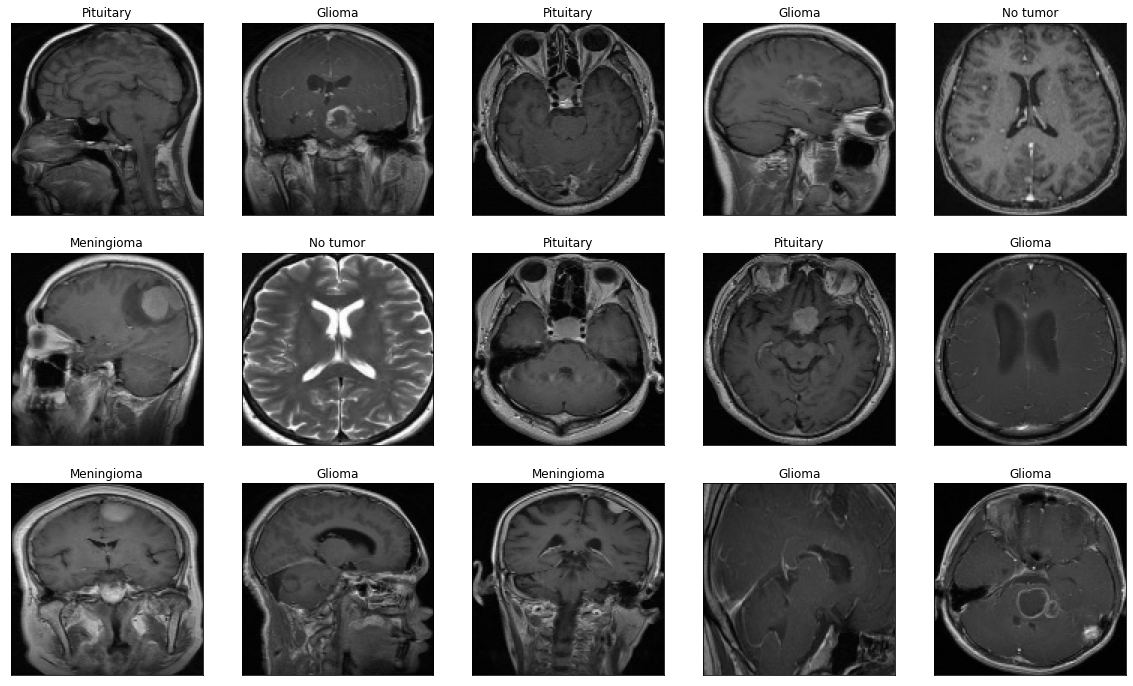

In [12]:
plt.figure(figsize=(20, 12))
for i in range(15):
  plt.subplot(3, 5, i+1)
  plt.title(dic[y_train[i]])
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_train[i])

In [13]:
sample = 0
print("Las características de una muestra de entrenamiento lucen como \n \n", x_train[sample][:1])

Las características de una muestra de entrenamiento lucen como 
 
 [[[  0   0   0]
  [  1   1   1]
  [  1   1   1]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  1   1   1]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  1   1   1]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  1   1   1]
  [  1   1   1]
  [  1   1   1]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  3   3   3]
  [  0   0   0]
  [  0   0   0]
  [  3   3   3]
  [  1   1   1]
  [  2   2   2]
  [  3   3   3]
  [  0   0   0]
  [  1   1   1]
  [  0   0   0]
  [  0   0   0]
  [  1   1   1]
  [  1   1   1]
  [  1   1   1]
  [  1   1   1]
  [  1   1   1]
  [  1   1   1]
  [  0   0   0]
  [  2   2   2]
  [  1   1   1]
  [  5   5   5]
  [  7   7   7]
  [ 17  17  17]
  [ 39  39  39]
  [ 66  66  66]
  [ 87  87  87]
  [103 103 103]
  [121 121 121]
  [140 140 140]
  [108 108 108]
  [ 62  62  62]
  [ 2

In [14]:
print("La etiqueta de la muestra de entrenamiento {} es: {}".format(sample, y_train[sample]))

La etiqueta de la muestra de entrenamiento 0 es: 3


<font color = "00008B" size = 3> ***ONE-HOT Y NORMALIZACIÓN*** </font>

Como ya vimos nuestras muestras de entrada no están normalizadas y además las etiquetas no están en representación one-hot, es por eso que cambiaremos las etiquetas y normalizaremos cada entrada dividiendo entre 225 que es el valor máximo que hay por cada pixel.  

In [15]:
# Realizamos la representación one-hot.
num_classes = 4

train_y = keras.utils.to_categorical(y_train, num_classes)
test_y = keras.utils.to_categorical(y_test, num_classes)

<center>

| Label | Class Name |
| --- | --- |
| [1. 0. 0. 0.] | No tumor |
| [0. 1. 0. 0.] | Glioma | 										
| [0. 0. 1. 0.] | Meningioma |										
| [0. 0. 0. 1.] | Pituitary |		

</center>		

In [16]:
#Normalizamos
train_x = x_train/255
test_x = x_test/255

In [17]:
print("Las características de una muestra de entrenamiento lucen como \n \n", train_x[sample][:1])

Las características de una muestra de entrenamiento lucen como 
 
 [[[0.         0.         0.        ]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.00392157 0.00392157 0.00392157]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.00392157 0.00392157 0.00392157]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.   

In [18]:
print("Las dimensiones de train_x son: ", train_x.shape)
print("Las dimensiones de train_y son: ", train_y.shape)

print("Las dimensiones de test_x son: ", test_x.shape)
print("Las dimensiones de test_y son: ", test_y.shape)

Las dimensiones de train_x son:  (5712, 128, 128, 3)
Las dimensiones de train_y son:  (5712, 4)
Las dimensiones de test_x son:  (1311, 128, 128, 3)
Las dimensiones de test_y son:  (1311, 4)


La muestra 0 corresponde a Pituitary.
Su representación one-hot es = [0. 0. 0. 1.]


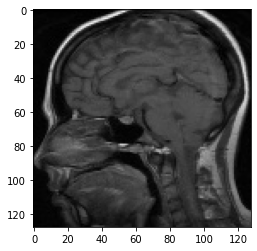

In [19]:
plt.imshow(train_x[sample]);
print("La muestra {} corresponde a {}.".format(sample, dic[int(np.argmax(train_y[sample]))]))
print("Su representación one-hot es =", train_y[sample])

<font color = "00008B" size = 5> ***ARQUITECTURA RED NEURONAL*** </font>

In [20]:
def architecture(input_shape, num_classes, activation):

    model = keras.Sequential([
       
          layers.Conv2D(28, kernel_size=(3, 3), padding="same", input_shape=input_shape, kernel_initializer="he_uniform", bias_initializer="zeros", activation=activation),
       
          layers.MaxPooling2D(pool_size=(2, 2)),
       
          layers.Conv2D(14, kernel_size=(3, 3), padding="same", kernel_initializer="he_uniform", bias_initializer="zeros", activation=activation),
       
          layers.MaxPooling2D(pool_size=(2, 2)),
       
          layers.Conv2D(7, kernel_size=(3, 3), padding="same", kernel_initializer="he_uniform", bias_initializer="zeros", activation=activation),
       
          layers.MaxPooling2D(pool_size=(2, 2)),
       
          layers.Dropout(0.2),
       
          layers.Flatten(),
       
          layers.Dropout(0.5),
       
          layers.Dense(512, kernel_initializer="he_uniform",bias_initializer="zeros"),
       
          layers.Dropout(0.5),
       
          layers.Dense(256, kernel_initializer="he_uniform",bias_initializer="zeros"),

          layers.Dropout(0.2),

          layers.Dense(128, kernel_initializer="he_uniform",bias_initializer="zeros"),

          layers.Dropout(0.5),
       
          layers.Dense(num_classes, activation="softmax"),
      ]
    ) 
    
    return model

In [21]:
input_shape = (128, 128, 3)
num_classes = 4
activation="relu"

model = architecture(input_shape, num_classes, activation)

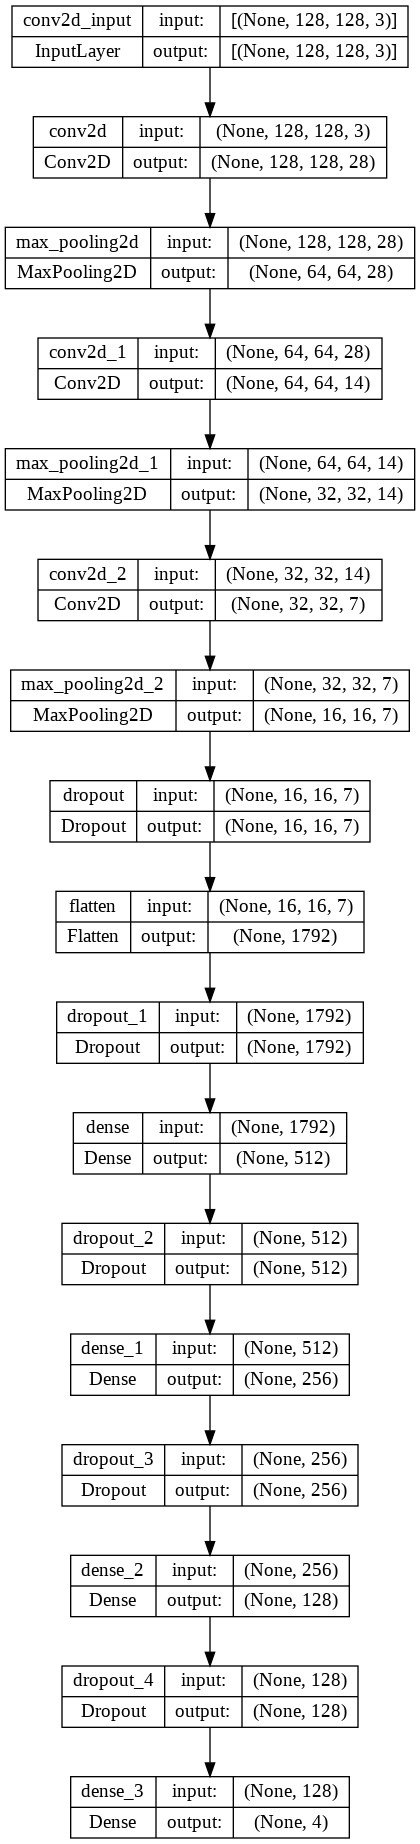

In [22]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 28)      784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 14)        3542      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 14)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 7)         889       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 7)        0

<font color = "00008B" size = 5> ***ENTRENAMIENTO*** </font>

In [24]:
learning_rate = 0.01
optimizer = "adam"

In [25]:
loss_function = "categorical_crossentropy"
metric_function = "accuracy"

In [26]:
model.compile(optimizer = optimizer, loss = loss_function, metrics = [metric_function])

In [27]:
start_time = time.time()

validation_portion = 0.1
batch_size= 64
num_epochs = 120

history = model.fit(x=train_x, y=train_y, epochs=num_epochs, batch_size=batch_size, \
                            validation_split=validation_portion, shuffle=True, verbose=1)

end_time = time.time()
print("Time for training: {:10.4f}s".format(end_time - start_time))

Epoch 1/120
81/81 [==============================] - 5s 31ms/step - loss: 1.2334 - accuracy: 0.4687 - val_loss: 0.8616 - val_accuracy: 0.6608
Epoch 2/120
81/81 [==============================] - 2s 29ms/step - loss: 0.8949 - accuracy: 0.6313 - val_loss: 0.6799 - val_accuracy: 0.7552
Epoch 3/120
81/81 [==============================] - 3s 32ms/step - loss: 0.7446 - accuracy: 0.6967 - val_loss: 0.5055 - val_accuracy: 0.8094
Epoch 4/120
81/81 [==============================] - 3s 32ms/step - loss: 0.6680 - accuracy: 0.7426 - val_loss: 0.5171 - val_accuracy: 0.7972
Epoch 5/120
81/81 [==============================] - 3s 32ms/step - loss: 0.6151 - accuracy: 0.7634 - val_loss: 0.4908 - val_accuracy: 0.7990
Epoch 6/120
81/81 [==============================] - 2s 26ms/step - loss: 0.5502 - accuracy: 0.8006 - val_loss: 0.4741 - val_accuracy: 0.8234
Epoch 7/120
81/81 [==============================] - 2s 27ms/step - loss: 0.5563 - accuracy: 0.7887 - val_loss: 0.5022 - val_accuracy: 0.8182
Epoch 

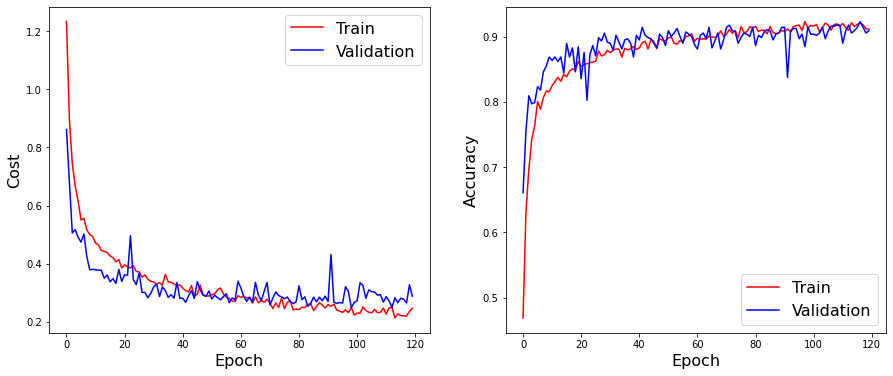

In [28]:
plt.figure(figsize=(15,6)) 

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)


ax1.plot(history.history["loss"], color="red")
ax1.plot(history.history["val_loss"], color="blue")
ax1.set_xlabel("Epoch",size=16)
ax1.set_ylabel("Cost", size=16)
ax1.legend(["Train", "Validation"], loc="upper right", fontsize=16)

ax2.plot(history.history["accuracy"], color="red")
ax2.plot(history.history["val_accuracy"], color="blue")
ax2.set_xlabel("Epoch",size=16)
ax2.set_ylabel("Accuracy", size=16)
ax2.legend(["Train", "Validation"], loc="lower right", fontsize=16)

In [29]:
evaluations = model.evaluate(x = test_x, y = test_y)

print ("Loss = " + str(evaluations[0]))
print ("Test Accuracy = " + str(evaluations[1]))

41/41 [==============================] - 1s 13ms/step - loss: 0.2943 - accuracy: 0.8986
Loss = 0.29425278306007385
Test Accuracy = 0.8985507488250732


<font color = "00008B" size = 5> ***PREDICCIONES*** </font>

Vamos a realizar unas cuentas predicciones para ver que tan bien (o mal) funciona nuestro modelo. Las predicciones se realizan sobre el conjunto test.  

In [30]:
predictions = model.predict(test_x)

41/41 [==============================] - 0s 6ms/step


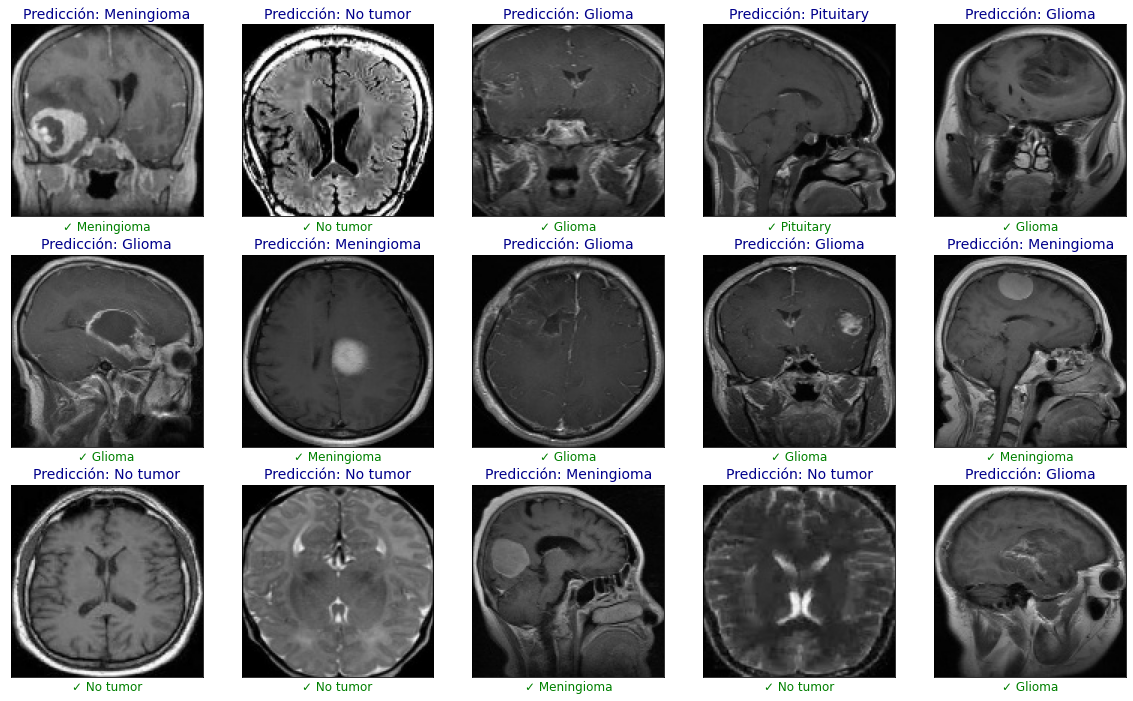

In [31]:
# Para poder entender un poco mejor como funciona el modelo y las predicciones
# vamos a mostrar las imágenes a las cuales se les realizó la predicción.

plt.figure(figsize=(20, 12))
for i in range(15):
  prediction = np.argmax(predictions[i])
  plt.subplot(3, 5, i+1)
  plt.title("Predicción: {}".format(dic[int(prediction)]), size = 14, color = "darkblue")
  if prediction == y_test[i]: 
    plt.xlabel("✓ {}".format(dic[int(np.argmax(test_y[i]))]), color = "green", size = 12)
  else:
    plt.xlabel("✗ {}".format(dic[int(np.argmax(test_y[i]))]), color = "red", size = 12)  
  plt.xticks([])
  plt.yticks([])
  plt.imshow(test_x[i])

In [32]:
model.save('/content/drive/MyDrive/BrainTumorClassification/modelBrainTumorClassificationCNN1.h5')



---


<font color = "00008B" size = 5> ***TRANSFER LEARNING*** </font>


---

<center> 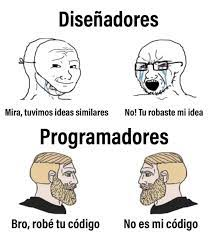 </center>



La utilización de Transfer Learning en Deep Learning consiste principalmente en utilizar redes neuronales pre-entrenadas.

**Utilización de modelos pre-entrenados como extractores de features.**

La arquitectura de estos modelos de Deep Learning se presenta frecuentemente bajo la forma de un compilado de capas de neuronas. Estas capas adquieren diferentes características en función del nivel en el que se sitúan. La última capa (generalmente una capa enteramente conectada, en el caso del aprendizaje supervisado), es utilizada para obtener el resultado final. La siguiente figura ilustra la arquitectura de un modelo de Deep Learning utilizado para la detección de gatos y perros. Mientras más profunda se sitúa la capa, más permite extraer features específicas.


<center> <img src='https://datascientest.com/es/wp-content/uploads/sites/7/2020/07/Capture-d%E2%80%99e%CC%81cran-2020-07-21-a%CC%80-08.45.40-1024x406.png.webp' width="550" height="300"/> </center>

La idea es reutilizar una red pre-entrenada sin capa final. Esta nueva red funciona como un extractor de features fijas para realizar otras tareas.

Información tomada de [¿Qué es el Transfer Learning?](https://datascientest.com/es/que-es-el-transfer-learning).

In [33]:
num_classes = 4

In [34]:
modelTL = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_050_128/feature_vector/5",
                   trainable=False),
    layers.Dense(512, kernel_initializer="he_uniform",bias_initializer="zeros"),
       
    tf.keras.layers.Dropout(0.5),
       
    tf.keras.layers.Dense(256, kernel_initializer="he_uniform",bias_initializer="zeros"),

    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(128, kernel_initializer="he_uniform",bias_initializer="zeros"),

    tf.keras.layers.Dropout(0.5),
       
    tf.keras.layers.Dense(num_classes, activation="softmax"),
])

modelTL.build([None, 128, 128, 3])

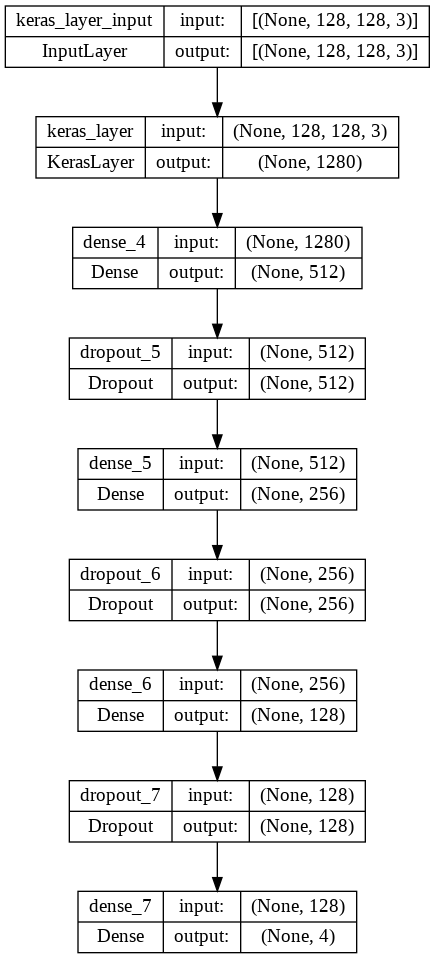

In [35]:
plot_model(modelTL, show_shapes=True, show_layer_names=True)

In [36]:
modelTL.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              706224    
                                                                 
 dense_4 (Dense)             (None, 512)               655872    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)              

In [37]:
learning_rate = 0.01
optimizer = "adam"

In [38]:
loss_function = "categorical_crossentropy"
metric_function = "accuracy"

In [39]:
modelTL.compile(optimizer = optimizer, loss = loss_function, metrics = [metric_function])

In [40]:
start_time = time.time()

validation_portion = 0.1
batch_size= 64
num_epochs = 40

historyTL = modelTL.fit(x=train_x, y=train_y, epochs=num_epochs, batch_size=batch_size, \
                            validation_split=validation_portion, shuffle=True, verbose=1)

end_time = time.time()
print("Time for training: {:10.4f}s".format(end_time - start_time))

Epoch 1/40
81/81 [==============================] - 6s 33ms/step - loss: 2.6342 - accuracy: 0.7212 - val_loss: 0.7324 - val_accuracy: 0.8811
Epoch 2/40
81/81 [==============================] - 2s 21ms/step - loss: 1.6378 - accuracy: 0.8045 - val_loss: 0.6524 - val_accuracy: 0.8916
Epoch 3/40
81/81 [==============================] - 2s 21ms/step - loss: 1.2846 - accuracy: 0.8263 - val_loss: 1.0843 - val_accuracy: 0.8357
Epoch 4/40
81/81 [==============================] - 2s 21ms/step - loss: 0.9852 - accuracy: 0.8539 - val_loss: 0.5172 - val_accuracy: 0.8864
Epoch 5/40
81/81 [==============================] - 2s 21ms/step - loss: 0.7361 - accuracy: 0.8671 - val_loss: 0.6042 - val_accuracy: 0.9021
Epoch 6/40
81/81 [==============================] - 2s 21ms/step - loss: 0.7102 - accuracy: 0.8708 - val_loss: 0.3748 - val_accuracy: 0.9196
Epoch 7/40
81/81 [==============================] - 2s 23ms/step - loss: 0.6256 - accuracy: 0.8770 - val_loss: 0.4820 - val_accuracy: 0.9056
Epoch 8/40
81

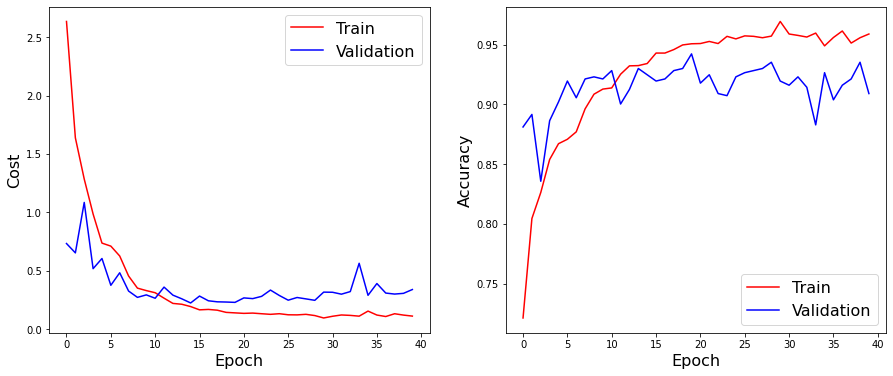

In [41]:
plt.figure(figsize=(15,6)) 

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)


ax1.plot(historyTL.history["loss"], color="red")
ax1.plot(historyTL.history["val_loss"], color="blue")
ax1.set_xlabel("Epoch",size=16)
ax1.set_ylabel("Cost", size=16)
ax1.legend(["Train", "Validation"], loc="upper right", fontsize=16)

ax2.plot(historyTL.history["accuracy"], color="red")
ax2.plot(historyTL.history["val_accuracy"], color="blue")
ax2.set_xlabel("Epoch",size=16)
ax2.set_ylabel("Accuracy", size=16)
ax2.legend(["Train", "Validation"], loc="lower right", fontsize=16)

In [42]:
evaluationsTL = modelTL.evaluate(x = test_x, y = test_y)

print ("Loss = " + str(evaluationsTL[0]))
print ("Test Accuracy = " + str(evaluationsTL[1]))

41/41 [==============================] - 1s 15ms/step - loss: 0.2400 - accuracy: 0.9298
Loss = 0.23998712003231049
Test Accuracy = 0.9298245906829834


In [43]:
predictionsTL = modelTL.predict(test_x)

41/41 [==============================] - 1s 11ms/step


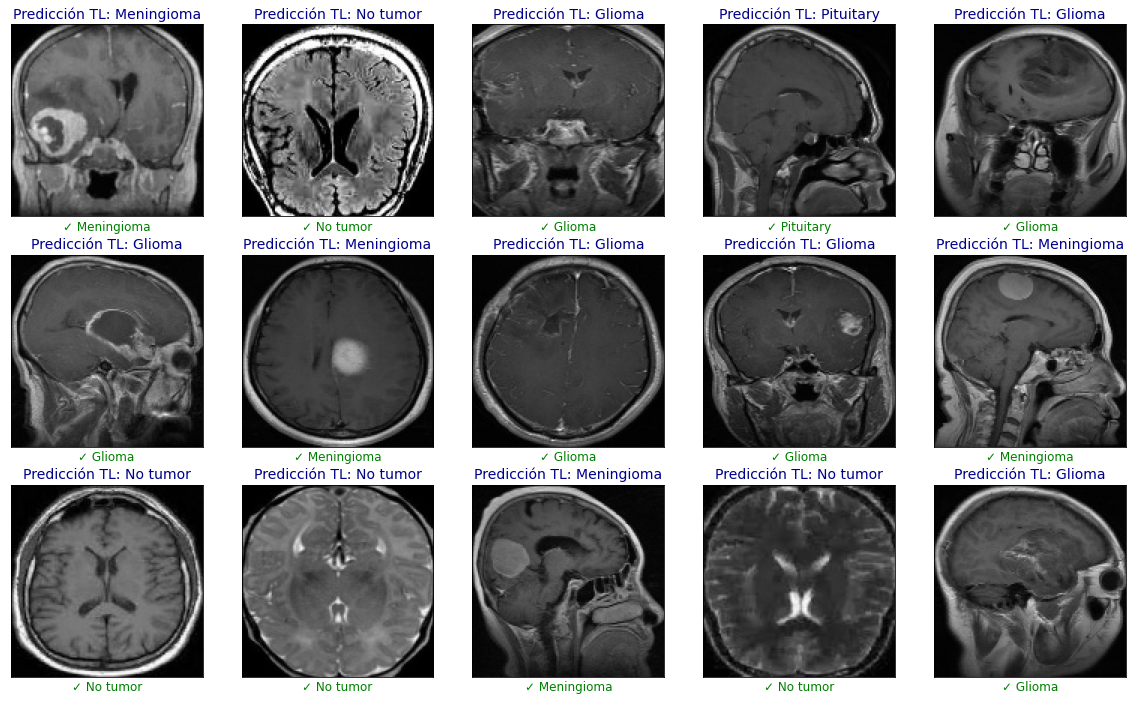

In [45]:
# Para poder entender un poco mejor como funciona el modelo y las predicciones
# vamos a mostrar las imágenes a las cuales se les realizó la predicción.

plt.figure(figsize=(20, 12))
for i in range(15):
  predictionTL = np.argmax(predictionsTL[i])
  plt.subplot(3, 5, i+1)
  plt.title("Predicción TL: {}".format(dic[int(predictionTL)]), size = 14, color = "darkblue")
  if predictionTL == y_test[i]: 
    plt.xlabel("✓ {}".format(dic[int(np.argmax(test_y[i]))]), color = "green", size = 12)
  else:
    plt.xlabel("✗ {}".format(dic[int(np.argmax(test_y[i]))]), color = "red", size = 12)  
  plt.xticks([])
  plt.yticks([])
  plt.imshow(test_x[i])

In [46]:
modelTL.save('/content/drive/MyDrive/BrainTumorClassification/modelBrainTumorClassificationTL.h5')